# Follow these instructions:

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

## Assignment Week 8: Text Mining using Dimensionality Reduction Methods [_/100 Marks]

This dataset comes from the #TidyTuesday repository and represents 2122 TV shows. In this assignment, we will apply dimensionality reduction methods to improve our understanding of text data and to predict the number of seasons of the TV shows. 

In [1]:
import numpy as np
import pandas as pd
#!pip install umap-learn
import umap
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA, TruncatedSVD
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from itertools import product
import string
import seaborn as sns
import matplotlib.pyplot as plt
seed = 0

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1: Decomposition of the texts [ /66 marks]

### Question 1.1

The dataset comes with the a few text variables and a categorical variable which represents whether a TV show has one season or more than one season. Import the data and create a new variable called 'full_description' by combining the three columns title, listed_in, and description. Keep the two columns,'duration' and 'full_description', and remove the rest. Do binary encoding for the traget variable 'duration'. Assign 1 to 'More than one season' and 0 to 'One season'. In the "full_description" column replace the word "Sci-Fi" with the word "Sci_Fi" since we would want to treat "Sci-Fi" as single word. Select the full_description column and display its first 10 rows. Use sklearn's `TfidfVectorizer` to eliminate accents, special characters, and stopwords (please see below to find out what stopwords need to be removed). In addition, make sure to eliminate words that appear in less than 5% of documents and those that appear in over 95%. You can also set `sublinear_tf` to `True`. After that, split the data into train and test with `test_size = 0.2` and `seed = seed`. Calculate the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for both train and test. Note that you need to fit and transform the inputs for the train set but you only need to transform the inputs for the test set. Don't forget to turn the sparse matrices to dense ones after you apply the `Tf-Idf` transform.  

In [2]:
# Load the data [ /1 mark]
raw_data = pd.read_csv('/content/Netflix_data.csv');
raw_data = raw_data.rename(columns ={'Unnamed: 0': 'title'});
# Create a new variable called 'full_description' by combining the three columns title, listed_in, and description [ /2 marks]
# use an empty space to concat these three columns
raw_data["full_description"] = raw_data['title'] + ' ' + raw_data['listed_in'] + ' ' +  raw_data['description'];
raw_data["full_description"];
# Keep two columns,'duration' and 'full_description', and remove the rest
data = pd.DataFrame({'duration':raw_data['duration'], 'full_description':raw_data['full_description']});
# Do binary encoding for the traget variable 'duration'. Assign 1 to 'More than one season' and 0 to 'One season' [ \1 mark]
duration = pd.get_dummies(data['duration']);

# In the "full_description" column replace the word "Sci-Fi" with the word "Sci_Fi" [ \1 mark]
data['duration'] = duration["More than one season"];
data['full_description'] = data['full_description'].str.replace('Sci-Fi','Sci_Fi');
# Select the following column and display its first 10 rows: full_description [ /1 mark]
data['full_description'][0:10]

0    3% International TV Shows, TV Dramas, TV Sci_F...
1    46 International TV Shows, TV Dramas, TV Myste...
2    1983 Crime TV Shows, International TV Shows, T...
3    1994 Crime TV Shows, Docuseries, International...
4    ​SAINT SEIYA: Knights of the Zodiac Anime Seri...
5    (Un)Well Reality TV This docuseries takes a de...
6    #blackAF TV Comedies Kenya Barris and his fami...
7    Şubat Crime TV Shows, International TV Shows, ...
8    100 Days My Prince International TV Shows, Rom...
9    100 Humans Docuseries, Science & Nature TV One...
Name: full_description, dtype: object

In [3]:

# Defining the TfIDFTransformer [ /4 marks]
transformer = sktext.TfidfTransformer(sublinear_tf= True)

# Define a vectors of stop words: stop words list must contain 'english' stop words, 'shows', and 'tv' 
stop_words = stopwords.words('english') + ['shows', 'tv']
vectorizer = sktext.TfidfVectorizer(stop_words=stop_words, strip_accents= 'unicode', sublinear_tf=True, min_df=0.05, max_df=0.95 );

# Train/test split [ /2 marks]
X_train, X_test, y_train, y_test = train_test_split(data['full_description'],data['duration'], random_state=seed, test_size=0.2)
# Calculate the Tf-Idf transform [ /2 marks]
TfIDF_train = transformer.fit_transform(vectorizer.fit_transform(X_train)).toarray()
TfIDF_test = transformer.transform(vectorizer.transform(X_test)).toarray()

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required). Print the number of indices in the ouput using [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [4]:
# Print the number of indices [ /2 marks]
print('Number of indices in output',len(transformer.get_feature_names_out()))

Number of indices in output 25


### Question 1.2
Now we have the TfIDF matrix so we can start working on the data. We hope to explore what some commonly occuring concepts are in the 'full_description' column. We can do this using PCA. A PCA transform of the TF-IDF matrix will give us a basis of the text data, each component representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic. Calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts.

Text(0, 0.5, 'Culmative Variance')

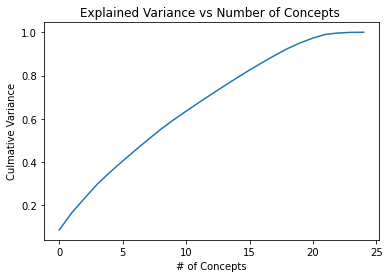

In [5]:
# Apply PCA on training data and get the explained variance [ / 4 marks]
pca = PCA(random_state=seed).fit(TfIDF_train)

# Plotting explained variance with number of concepts [ / 4 marks]
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Explained Variance vs Number of Concepts ")
plt.xlabel('# of Concepts')
plt.ylabel('Culmative Variance')


**Question:** Exactly how many concepts do we need to correctly explain at least 80% of the data?


In [6]:
# To get the exact index where the variance is above 80% [ / 4 marks]
count = 0
for i in np.cumsum(pca.explained_variance_ratio_):
  count += 1;
  if(i>0.8): 
    print('Min concepts needed for at least 80%: ', count);
    print('Percentage: ', np.round(i*100,2), '%')
    break

Min concepts needed for at least 80%:  16
Percentage:  82.52 %


**Your Answer:** 
Min concepts needed for at least 80%:  16
Percentage:  81.11 %

### Question 1.3

Let's examine the first three concepts by looking how many variance they explained and showing the 10 words that are the most important in each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).


In [7]:
# Explained variance [ / 2 marks]
variance = pca.explained_variance_
print(variance)

[0.07836431 0.07302354 0.0601857  0.0590624  0.05014091 0.04671702
 0.04553538 0.0443156  0.04317561 0.03943983 0.03671144 0.03599019
 0.03516331 0.03450305 0.03407668 0.03280801 0.03155275 0.03008973
 0.02859595 0.02404865 0.01989002 0.0157033  0.00565162 0.00258531
 0.00059378]


In [8]:
# Get 10 most important words for each component [ / 4 marks]
top10 = []
for i in range(3):
    words =  np.argsort(np.abs(pca.components_[i]))[:10]
    top10.append(vectorizer.get_feature_names_out()[words] )
    

In [9]:
# Words for concept 1 [ / 2 marks]
print('Concept 1: ', top10[0])

Concept 1:  ['world' 'life' 'series' 'romantic' 'reality' 'kids' 'family' 'new' 'two'
 'school']


In [10]:
# Words for concept 2 [ / 2 marks]
print('Concept 2: ', top10[1])


Concept 2:  ['anime' 'crime' 'two' 'young' 'school' 'action' 'love' 'adventure'
 'language' 'life']


In [11]:
# Words for concept 3 [ / 2 marks]
print('Concept 3: ', top10[2])


Concept 3:  ['dramas' 'friends' 'series' 'world' 'new' 'family' 'romantic' 'school'
 'life' 'love']


### Question 1.4

 Apply the PCA transformation to the test dataset. Use only the first two components and make a scatter plot of the TV shows. Identify the 'More than one season' TV shows, and 'One season' TV shows by colouring points with different colours. Make sure to add a legend to your plot!

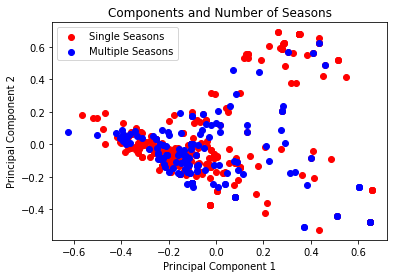

In [12]:
# Apply PCA to the test dataset [ / 2 marks]
testpca = pca.transform(TfIDF_test)

# Plot the two different set of points with different markers and labels [ /4 marks]
for i, label in enumerate(set(y_test)):
    x = 'Multiple Seasons'
    if(label == 0):
      x = 'Single Seasons'
    plt.scatter(testpca[:,0][y_test==label], testpca[:,1][y_test==label], c=['red','blue'][i], label=x)

plt.title('Components and Number of Seasons')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


**Question:** What can we say about where 'More than one season' TV shows and 'One season' TV shows lie in our plot? Could we use these concepts to discriminate these cases? If yes, why? If no, why not? Discuss your findings. [ /2 marks]
 
**Your answer:** 
No these concepts wouldnt' work as the data seems to be pretty clusttered although it seems multiplr seasons is usuaslly

### Question  1.5

Repeat the process above, only now using a UMAP projection with two components. Test all combinations of ```n_neighbors=[2, 10, 25, 35, 45]``` and ```min_dist=[0.1, 0.25, 0.5, 1]``` over the train data and choose the projection that you think is best, and apply it over the test data. Use 1000 epochs, a cosine metric and random initialization. If you have more than 8GB of RAM (as in Colab), you may want to set ```low_memory=False``` to speed up computations.

*Hint: [This link](https://stackoverflow.com/questions/16384109/iterate-over-all-combinations-of-values-in-multiple-lists-in-python) may be helpful.*



In [13]:
# Set parameters
n_neighbors=[2, 10, 25, 35, 45]
min_dist=[0.1, 0.25, 0.5, 1]
# Create UMAP and plots [ / 8 marks]
prod = list(product(n_neighbors, min_dist))
umapBeta = []
for i in  prod:
  umapBeta.append(umap.UMAP(init='random',low_memory=False,n_components=2, random_state=seed,  n_epochs=1000,n_neighbors=i[0], min_dist=i[1],metric='cosine', n_jobs=-1).fit_transform(TfIDF_train))
  print(i)


(2, 0.1)
(2, 0.25)
(2, 0.5)
(2, 1)
(10, 0.1)
(10, 0.25)
(10, 0.5)
(10, 1)
(25, 0.1)
(25, 0.25)
(25, 0.5)
(25, 1)
(35, 0.1)
(35, 0.25)
(35, 0.5)
(35, 1)
(45, 0.1)
(45, 0.25)
(45, 0.5)
(45, 1)


In [14]:
# n = list(product(n_neighbors, min_dist))
# count = 0
# for i in umapBeta:
#   for r, label in enumerate(set(y_train)):
#     x = 'Multiple Seasons'
#     if(label == 0):
#       x = 'Single Seasons'
#     plt.scatter(i[:,0][y_train==label], i[:,1][y_train==label], c=['red','blue'][r], label = x)
#   plt.title('N_Neighbours = ' + str(n[count][0]) + ' min_dist = ' + str(n[count][1]))
#   plt.legend()
#   plt.show()
#   count+=1


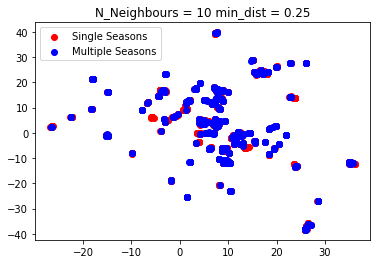

In [15]:
# Create plot
train_umap = umapBeta[5]
for r, label in enumerate(set(y_train)):
    x = 'Multiple Seasons'
    if(label == 0):
      x = 'Single Seasons'
    plt.scatter(umapBeta[5][:,0][y_train==label], umapBeta[5][:,1][y_train==label], c=['red','blue'][r], label = x)
    plt.title('N_Neighbours = ' + str(prod[5][0]) + ' min_dist = ' + str(prod[9][1]))
    plt.legend()

**Question:** Which paramter would you choose? [ / 2 marks]

**Your Answer:** 
Id go with n_neighbours 25 min_dist 0.25 as this seems to keep the structure of the data while still producing more distinct clusters

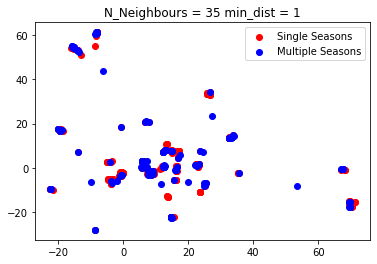

In [16]:
# Choose the paramters that you think are best and apply to test set [ / 4 marks]
umap_test =umap.UMAP(init='random',low_memory=False,n_components=2,random_state=seed,  n_epochs=1000,n_neighbors=25, min_dist=0.25,metric='cosine', n_jobs=-1).fit(TfIDF_train).transform(TfIDF_test)
# Create plot [ /2 marks]
for r, label in enumerate(set(y_test)):
    x = 'Multiple Seasons'
    if(label == 0):
      x = 'Single Seasons'
    plt.scatter(umap_test[:,0][y_test==label], umap_test[:,1][y_test==label], c=['red','blue'][r], label = x)
    plt.title('N_Neighbours = 35' + ' min_dist = 1' )
    plt.legend()


**Question:** How does the plot compare to the PCA one? [ /2 marks]

**Your answer:** 
I think it retains alot of the structure while reducing comolexity as a lot more data points seems to overlap.

## Task 2: Benchmarking predictive capabilities of the compressed data [ / 34 marks]

For this task, we will benchmark the predictive capabilities of the compressed data against the original one. 



### Question 2.1 
Train a regularized logistic regression over the original TfIDF train set using l2 regularization. Calculate the AUC score and plot the ROC curve for the original test set.

AUC Score  0.64
[{'tpr': 0.0, 'fpr': 0.0, 'thr': 0.5940998111266906}, {'tpr': 0.006993006993006993, 'fpr': 0.0, 'thr': -0.4059001888733093}, {'tpr': 0.013986013986013986, 'fpr': 0.0, 'thr': -0.44815689383488233}, {'tpr': 0.013986013986013986, 'fpr': 0.0070921985815602835, 'thr': -0.4739128585960613}, {'tpr': 0.02097902097902098, 'fpr': 0.0070921985815602835, 'thr': -0.4782343864070224}, {'tpr': 0.027972027972027972, 'fpr': 0.010638297872340425, 'thr': -0.48625965206002997}, {'tpr': 0.027972027972027972, 'fpr': 0.02127659574468085, 'thr': -0.5234021138558312}, {'tpr': 0.04195804195804196, 'fpr': 0.02127659574468085, 'thr': -0.5380346442850622}, {'tpr': 0.04195804195804196, 'fpr': 0.03900709219858156, 'thr': -0.5459299201041955}, {'tpr': 0.04195804195804196, 'fpr': 0.04609929078014184, 'thr': -0.5546075437132664}, {'tpr': 0.055944055944055944, 'fpr': 0.04964539007092199, 'thr': -0.5598032181281046}, {'tpr': 0.055944055944055944, 'fpr': 0.05319148936170213, 'thr': -0.5623357613497341}, {'

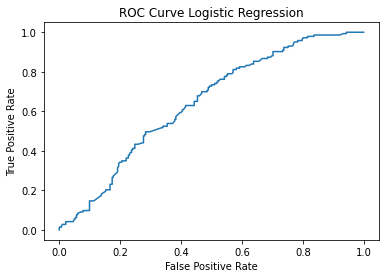

In [17]:
# Train and test using model LogisticRegressionCV [ /3 marks]
# roc_curve, roc_auc_score, auc
# Define the model
x = LogisticRegressionCV(cv = StratifiedKFold(),random_state=seed)

# Fit on the training dataset
x.fit(X = TfIDF_train,y= y_train)

# Apply to the test dataset
y_pred = x.predict_log_proba(TfIDF_test)[:,1]

# Plot ROC curve and compute AUC score [ /2 marks]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)

lg_curve = []
# Calculate the ROC curve points
for i in range(len(tpr)):
  lg_curve.append({'tpr': tpr[i], 'fpr':fpr[i],'thr': thresholds[i]})
# Save the AUC in a variable to display it. Round it first
aucLR = np.round(auc(fpr,tpr),2)
print('AUC Score ',aucLR)
print(lg_curve)
# Create and show the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression' )
plt.show()

### Question 2.2 
Train a regularized logistic regression over an SVD-reduced dataset (with 13 components) using l2 regularization. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set.

[{'tpr': 0.0, 'fpr': 0.0, 'thr': 0.6393155020887414}, {'tpr': 0.006993006993006993, 'fpr': 0.0, 'thr': -0.36068449791125856}, {'tpr': 0.006993006993006993, 'fpr': 0.0035460992907801418, 'thr': -0.3902782903614263}, {'tpr': 0.006993006993006993, 'fpr': 0.010638297872340425, 'thr': -0.39599927127974305}, {'tpr': 0.006993006993006993, 'fpr': 0.02127659574468085, 'thr': -0.41926712369016017}, {'tpr': 0.013986013986013986, 'fpr': 0.02127659574468085, 'thr': -0.42766265099215883}, {'tpr': 0.013986013986013986, 'fpr': 0.024822695035460994, 'thr': -0.44828300061715975}, {'tpr': 0.02097902097902098, 'fpr': 0.024822695035460994, 'thr': -0.46086555226714027}, {'tpr': 0.02097902097902098, 'fpr': 0.03546099290780142, 'thr': -0.47361426284114627}, {'tpr': 0.027972027972027972, 'fpr': 0.03546099290780142, 'thr': -0.4736435178907205}, {'tpr': 0.027972027972027972, 'fpr': 0.0425531914893617, 'thr': -0.49321316617346206}, {'tpr': 0.027972027972027972, 'fpr': 0.04609929078014184, 'thr': -0.50485929334559

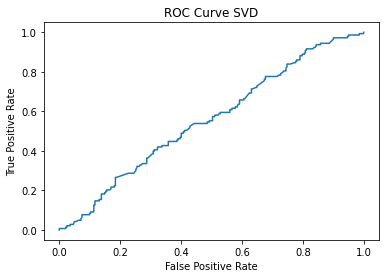

In [26]:
# Apply SVD first [ / 4 marks]
svdX_train = TruncatedSVD(random_state=seed,n_components=13).fit_transform(TfIDF_train)
svdX_test =  TruncatedSVD(random_state=seed,n_components=13).fit_transform(TfIDF_test)
x = LogisticRegressionCV(random_state=seed, cv = StratifiedKFold())

#Train and test using model LogisticRegressionCV [ /3 marks]
x.fit(svdX_train, y_train)
y_pred = x.predict_log_proba(svdX_test)[:,1]
# Plot ROC curve and compute AUC score [ /2 marks]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
lg_curve = []
# Calculate the ROC curve points
for i in range(len(tpr)):
  lg_curve.append({'tpr': tpr[i], 'fpr':fpr[i],'thr': thresholds[i]})
print(lg_curve)
# Save the AUC in a variable to display it. Round it first
aucSVD = np.round(auc(fpr,tpr),2)
print('AUC Score ',aucSVD)
# Create and show the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVD' )
plt.show()


### Question 2.3 
Train a regularized logistic regression over the UMAP-reduced dataset (with 13 components using the same parameters as Task 1.5) using l2 regularization. Calculate the AUC score and plot the ROC curve for the UMAP-transformed test set.

[{'tpr': 0.0, 'fpr': 0.0, 'thr': 1.4301509828971608}, {'tpr': 0.006993006993006993, 'fpr': 0.0, 'thr': 0.4301509828971609}, {'tpr': 0.006993006993006993, 'fpr': 0.0070921985815602835, 'thr': 0.4145803622631586}, {'tpr': 0.013986013986013986, 'fpr': 0.0070921985815602835, 'thr': 0.414536475789242}, {'tpr': 0.013986013986013986, 'fpr': 0.01773049645390071, 'thr': 0.4143177140169628}, {'tpr': 0.027972027972027972, 'fpr': 0.01773049645390071, 'thr': 0.4141344621274091}, {'tpr': 0.027972027972027972, 'fpr': 0.02127659574468085, 'thr': 0.4141138838179192}, {'tpr': 0.03496503496503497, 'fpr': 0.02127659574468085, 'thr': 0.4140819517127627}, {'tpr': 0.03496503496503497, 'fpr': 0.028368794326241134, 'thr': 0.41390186844150245}, {'tpr': 0.04895104895104895, 'fpr': 0.028368794326241134, 'thr': 0.41364728073083623}, {'tpr': 0.04895104895104895, 'fpr': 0.031914893617021274, 'thr': 0.4135478352755291}, {'tpr': 0.055944055944055944, 'fpr': 0.031914893617021274, 'thr': 0.4134193492598877}, {'tpr': 0.0

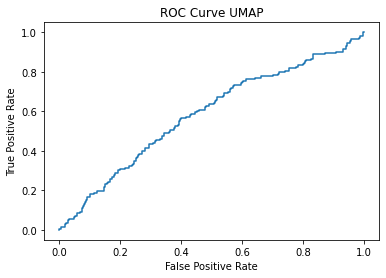

In [25]:
# Apply UMAP first [ / 3 marks]

UMAP_Final = umap.UMAP(n_components=13, init='random',low_memory=False, random_state=seed,  n_epochs=1000,n_neighbors=25, min_dist=0.25,metric='cosine', n_jobs=-1)
UMAP_train = UMAP_Final.fit_transform(TfIDF_train)
UMAP_test = UMAP_Final.transform(TfIDF_test)
x = LogisticRegressionCV(random_state=seed,cv = StratifiedKFold())

#Train and test using model LogisticRegressionCV [ /3 marks]
x.fit(UMAP_train, y_train)
y_pred = x.predict_proba(UMAP_test)[:,1]
# Plot ROC curve and compute AUC score [ /2 marks]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
lg_curve = []
# Calculate the ROC curve points
for i in range(len(tpr)):
  lg_curve.append({'tpr': tpr[i], 'fpr':fpr[i],'thr': thresholds[i]})
print(lg_curve)
# Save the AUC in a variable to display it. Round it first
aucUMAP = np.round(auc(fpr,tpr),2)
print('AUC Score ',aucUMAP)
# Create and show the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve UMAP' )
plt.show()


### Question 2.4
Train a XGBoost model over the SVD-reduced dataset prepared in Question 2.2. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set. In your model set ``num_boost_round=10`` and ``early_stopping_rounds=2``. You need to do CV using the training dataset, and then get best iteration based on cross-validation results. Finally, train the model on full training dataset with best number of iterations.

train-logloss-mean    0.551919
train-logloss-std     0.002905
test-logloss-mean     0.614074
test-logloss-std      0.008917
Name: 9, dtype: float64
AUC Score  0.55


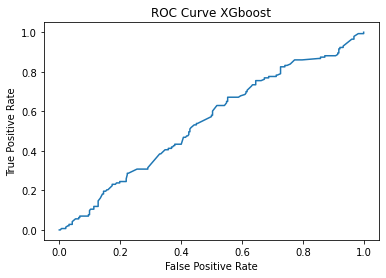

In [20]:
# Define XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 3,
}

# Define cross-validation object
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
# Perform cross-validation with XGBoost [ \3 marks]
dtrain = xgb.DMatrix(svdX_train, label=y_train)
cv_results = xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, folds=kf, early_stopping_rounds=2)

# Get best iteration based on cross-validation results [\ 1 mark]
print(pd.DataFrame(cv_results).iloc[-1])
# Train final model on full dataset with best number of iterations [\ 2 mark]
model = xgb.train(params, dtrain, num_boost_round=9)

# Compute predicted probabilities on the test set [\ 1 mark]
y_pred = model.predict(xgb.DMatrix(svdX_test, label=y_test))
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
# Save the AUC in a variable to display it. Round it first
aucUMAP = np.round(auc(fpr,tpr),2)
print('AUC Score ',aucUMAP)
# Create and show the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGboost' )
plt.show()


### Question 2.5
Compare the performance of the four models. Which one is the best. [ / 2 marks] 

**Your Answer:** 

The first one was the best model I got I believe i went wrong somewhere but not sure how or where.